In [5]:

# We can easily calculate distances between Org_airport_lat + Org_airport_long and Dest_airport_lat + Dest_airport_long
# Based on this information, we can plot the routes of all flichts and then we can calcualte the most fly-over states.


In [32]:

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from haversine import haversine, Unit

df = pd.read_csv ('C:\\Users\\Airports\\Airports.csv')

# Calculate the distance using the haversine formula
def calculate_distance(row):
    origin = (row['Org_airport_lat'], row['Org_airport_long'])
    destination = (row['Dest_airport_lat'], row['Dest_airport_long'])
    distance = haversine(origin, destination, unit=Unit.KILOMETERS)
    return distance

df['Distance_km'] = df.apply(calculate_distance, axis=1)

df = df.fillna(0)

# let's look at a random sample because processing all would take a very, very, very long time
sample = df.sample(n=200)
print(sample.shape)
print(sample.head())


(200, 16)
       Origin_airport Destination_airport      Origin_city Destination_city  Passengers  Seats  Flights  Distance   Fly_date  Origin_population  Destination_population  Org_airport_lat  Org_airport_long  Dest_airport_lat  Dest_airport_long  Distance_km
107465            LAS                 OMA    Las Vegas, NV        Omaha, NE        7876   8494       62      1099   3/1/2004            1646875                  800459        36.080101       -115.152000         41.303200         -95.894096  1764.901848
18191             LAX                 RNO  Los Angeles, CA         Reno, NV        7099  11782       86       390   9/1/1996           23326070                  301240        33.942501       -118.407997         39.499100        -119.767998   629.619922
981488            MSN                 DTW      Madison, WI      Detroit, MI          42     78        1       312   4/1/2003             526419                 8985512        43.139900        -89.337502         42.212399         -8

In [33]:

# Let's plot origin airports and destination airports on a map.

import pandas as pd
import folium
from folium.plugins import AntPath


# Create a base map centered around the United States
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Add routes to the map
for idx, row in sample.iterrows():
    origin = (row['Org_airport_lat'], row['Org_airport_long'])
    destination = (row['Dest_airport_lat'], row['Dest_airport_long'])
    folium.Marker(origin, tooltip="Origin").add_to(m)
    folium.Marker(destination, tooltip="Destination").add_to(m)
    # Add AntPath for better visualization of the route
    AntPath(
        locations=[origin, destination],
        color='blue',
        weight=2,
        opacity=0.8
    ).add_to(m)

# Save map to an HTML file
# m.save('routes_map.html')

# To display the map inline in a Jupyter notebook, use:
m


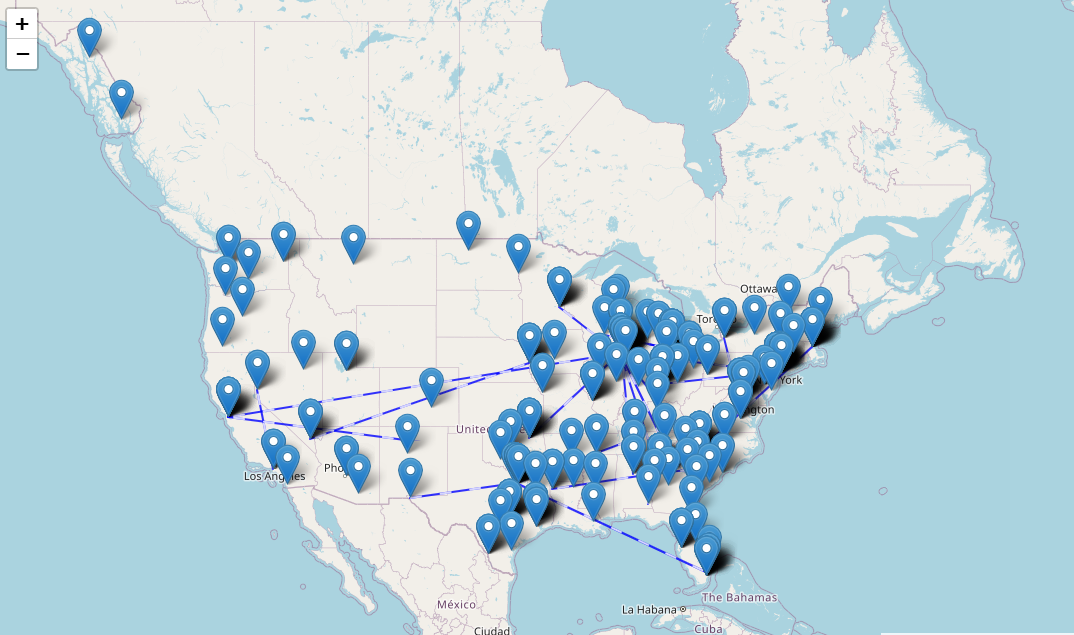

In [34]:

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "C:\\Users\\Airports\\"
Image(filename = PATH + "1.png")


In [11]:

# To determine all the states that each plane flies over, you need to calculate the flight path of each plane and determine which states 
# intersect with these paths. This is a complex problem that involves geographic calculations and spatial analysis.

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

# Load flight data
df = pd.read_csv('C:\\Users\\Airports\\Airports.csv')

# Load state boundaries from GeoJSON
states = gpd.read_file('C:\\Users\\Airports\\gz_2010_us_outline_500k.json')

# Ensure the CRS (coordinate reference system) is the same for both datasets
states = states.to_crs(epsg=4326)  # WGS84 Latitude/Longitude
print(states.columns)
print(states.head())


       TYPE R_STATEFP L_STATEFP  \
0  CANADIAN        53             
1  CANADIAN        30             
2   COASTAL        53             
3   COASTAL                  53   
4   COASTAL        53             

                                            geometry  
0  LINESTRING (-122.75802 49.00236, -122.40783 49...  
1  LINESTRING (-116.04919 49.00091, -116.00103 49...  
2  LINESTRING (-123.03539 49.00215, -123.02146 48...  
3  LINESTRING (-123.02549 48.71797, -123.04018 48...  
4  LINESTRING (-122.69591 48.73727, -122.66895 48...  


In [31]:

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

# Load flight data
df = pd.read_csv('C:\\Users\\Airports\\Airports.csv')

# Take a random sample of 100 rows from the data (adjust the number as needed)
df_sample = df.sample(n=10000, random_state=42)

# Load state boundaries from GeoJSON
states = gpd.read_file('C:\\Users\\Airports\\gz_2010_us_outline_500k.json')

# Ensure the CRS (coordinate reference system) is the same for both datasets
states = states.to_crs(epsg=4326)  # WGS84 Latitude/Longitude

# Print column names of the states GeoDataFrame to verify the correct column name
print(states.columns)

# Function to calculate flight path as a LineString
def calculate_flight_path(row):
    try:
        if pd.isna(row['Org_airport_lat']) or pd.isna(row['Org_airport_long']) or pd.isna(row['Dest_airport_lat']) or pd.isna(row['Dest_airport_long']):
            return None
        origin = Point(row['Org_airport_long'], row['Org_airport_lat'])
        destination = Point(row['Dest_airport_long'], row['Dest_airport_lat'])
        return LineString([origin, destination])
    except Exception as e:
        print(f"Error processing row: {e}")
        return None

# Apply the function to create a new column 'Flight_path' on the sample
df_sample['Flight_path'] = df_sample.apply(calculate_flight_path, axis=1)

# Drop rows where 'Flight_path' is None
df_sample = df_sample.dropna(subset=['Flight_path'])

# Convert DataFrame to GeoDataFrame
gdf_sample = gpd.GeoDataFrame(df_sample, geometry='Flight_path')

# Create a dictionary for FIPS codes to state names
fips_to_state = {
    '01': 'Alabama', '02': 'Alaska', '04': 'Arizona', '05': 'Arkansas', '06': 'California', '08': 'Colorado',
    '09': 'Connecticut', '10': 'Delaware', '11': 'District of Columbia', '12': 'Florida', '13': 'Georgia',
    '15': 'Hawaii', '16': 'Idaho', '17': 'Illinois', '18': 'Indiana', '19': 'Iowa', '20': 'Kansas', '21': 'Kentucky',
    '22': 'Louisiana', '23': 'Maine', '24': 'Maryland', '25': 'Massachusetts', '26': 'Michigan', '27': 'Minnesota',
    '28': 'Mississippi', '29': 'Missouri', '30': 'Montana', '31': 'Nebraska', '32': 'Nevada', '33': 'New Hampshire',
    '34': 'New Jersey', '35': 'New Mexico', '36': 'New York', '37': 'North Carolina', '38': 'North Dakota', '39': 'Ohio',
    '40': 'Oklahoma', '41': 'Oregon', '42': 'Pennsylvania', '44': 'Rhode Island', '45': 'South Carolina', '46': 'South Dakota',
    '47': 'Tennessee', '48': 'Texas', '49': 'Utah', '50': 'Vermont', '51': 'Virginia', '53': 'Washington', '54': 'West Virginia',
    '55': 'Wisconsin', '56': 'Wyoming'
}

# Function to find intersected states
def find_intersected_states(flight_path):
    intersected_states = states[states.geometry.intersects(flight_path)]
    state_fips_codes = intersected_states['R_STATEFP'].tolist()  # Using 'R_STATEFP'
    state_names = []
    for code in state_fips_codes:
        state_name = fips_to_state.get(code, "Unknown")
        #if state_name == "Unknown":
            #print(f"Unknown FIPS code: {code}")
        state_names.append(state_name)
    return state_names

# Apply the function to create a new column 'States_flown_over'
gdf_sample['States_flown_over'] = gdf_sample['Flight_path'].apply(find_intersected_states)

# Flatten the list of states and count the occurrences
all_states = [state for sublist in gdf_sample['States_flown_over'] for state in sublist]
state_counts = pd.Series(all_states).value_counts()

# Display the counts of each state
print(state_counts)

# Display a limited number of rows to avoid excessive output
print(gdf_sample[['Origin_airport', 'Destination_airport', 'States_flown_over']].head(20))


Index(['TYPE', 'R_STATEFP', 'L_STATEFP', 'geometry'], dtype='object')
Unknown           3798
Florida           1106
Michigan          1069
Illinois           930
New York           768
Ohio               717
New Jersey         566
Virginia           473
North Carolina     455
Alaska             322
Connecticut        283
California         213
Louisiana          152
Georgia             60
Maine               60
Hawaii              50
Massachusetts       42
Montana             32
Arizona             24
Maryland            23
Rhode Island        10
Washington           6
New Hampshire        2
Texas                1
Mississippi          1
dtype: int64
        Origin_airport Destination_airport                                  States_flown_over
781974             CLT                 ORD                                                 []
937737             ATL                 DTW                                    [Unknown, Ohio]
907828             ANC                 ORD  [Montana, Alaska

In [ ]:

# We are getting a bunch of 'unknown' records. Not sure why. Maybe the data is bad. Anyway, the top three flyover states are as follows:
# Florida           1106
# Michigan          1069
# Illinois           930


In [ ]:

# Data sources:

# https://www.kaggle.com/datasets/flashgordon/usa-airport-dataset?resource=download
# https://eric.clst.org/tech/usgeojson/


In [ ]:

# END!!!
